In [3]:
import os
import cv2
import numpy as np
from collections import defaultdict

import seaborn as sns
from matplotlib import pyplot

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import TimeDistributed, LSTM, Bidirectional
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

2025-09-22 15:10:43.432009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758553843.838267      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758553843.944414      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
INPUT_PATH = "../input/ck48-5-emotions/CK+48/"

for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
    print(f"{dir_} has {count} number of images")
    

surprise has 249 number of images
fear has 75 number of images
sadness has 84 number of images
happy has 207 number of images
anger has 135 number of images


In [6]:
TOP_EMOTIONS = ["happy", "surprise", "anger", "sadness", "fear"]

In [7]:
INPUT_PATH = "../input/ck48-5-emotions/CK+48/"

data = defaultdict(str)
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        data[dir_] = defaultdict(list)
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            sub = f.split("_")[0]
            data[dir_][sub].append(f)

In [8]:
def preprocess_list(x):
    return int((x.split("_")[2]).split(".")[0])

def preprocess_dict(x):
    res = list(np.argsort(list(map(preprocess_list, x))))
    return [x[i] for i in res]

def img2array(x,path):
    arr = np.empty(shape=(3,48,48))
    for i,f in enumerate(x):
        img = cv2.imread(path+f, 0)
        arr[i] = img
    return arr

In [9]:
for emotion in data:
    data[emotion] = dict((k, preprocess_dict(v)) for k, v in data[emotion].items())
    data[emotion] = dict((k, img2array(v, path=INPUT_PATH + emotion + "/")) for k, v in data[emotion].items())
    
for k,v in data.items():
    print(f"{k} has {len(v)} samples")

surprise has 83 samples
fear has 25 samples
sadness has 28 samples
happy has 69 samples
anger has 45 samples


In [10]:
print(data)

defaultdict(<class 'str'>, {'surprise': {'S071': array([[[ 85.,  85.,  85., ...,  99.,  98.,  97.],
        [ 84.,  85.,  86., ...,  98.,  97.,  97.],
        [ 84.,  85.,  85., ...,  98.,  99.,  99.],
        ...,
        [ 71.,  69., 109., ...,  80.,  80.,  80.],
        [ 73., 139., 195., ...,  80.,  79.,  78.],
        [148., 204., 208., ..., 114.,  80.,  75.]],

       [[ 84.,  84.,  84., ...,  97.,  97.,  97.],
        [ 82.,  84.,  85., ...,  97.,  97.,  96.],
        [ 83.,  84.,  84., ...,  97.,  99.,  97.],
        ...,
        [ 70.,  65.,  95., ...,  80.,  81.,  79.],
        [ 68., 126., 185., ...,  79.,  78.,  78.],
        [134., 201., 200., ...,  91.,  77.,  75.]],

       [[ 84.,  84.,  84., ...,  97.,  97.,  95.],
        [ 83.,  83.,  84., ...,  97.,  96.,  95.],
        [ 83.,  84.,  84., ...,  97.,  97.,  96.],
        ...,
        [ 66.,  86., 151., ...,  79.,  79.,  79.],
        [ 95., 175., 203., ...,  79.,  77.,  77.],
        [173., 212., 194., ...,  93.,  77

In [11]:
surprise = np.stack(list(data["surprise"].values()), axis=0)
surprise = surprise.reshape(*surprise.shape, 1)

happy = np.stack(list(data["happy"].values()), axis=0)
happy = happy.reshape(*happy.shape, 1)

anger = np.stack(list(data["anger"].values()), axis=0)
anger = anger.reshape(*anger.shape, 1)

sadness = np.stack(list(data["sadness"].values()), axis=0)
sadness = sadness.reshape(*sadness.shape, 1)

fear = np.stack(list(data["fear"].values()), axis=0)
fear = fear.reshape(*fear.shape, 1)
X = np.concatenate((surprise, happy, anger, sadness, fear))
y = np.concatenate((np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25)))
y = to_categorical(y)

print(X.shape, y.shape) 

(250, 3, 48, 48, 1) (250, 5)


In [12]:
label_emotion_mapper = {0:"surprise", 1:"happy", 2:"anger", 3:"sadness", 4:"fear"}

X_train, X_valid, y_train, y_valid = train_test_split(
  X,
  y,
  train_size=0.7,
  stratify=y,
  shuffle=True,
  random_state=42
)

print(X_train.shape, X_valid.shape)

(175, 3, 48, 48, 1) (75, 3, 48, 48, 1)


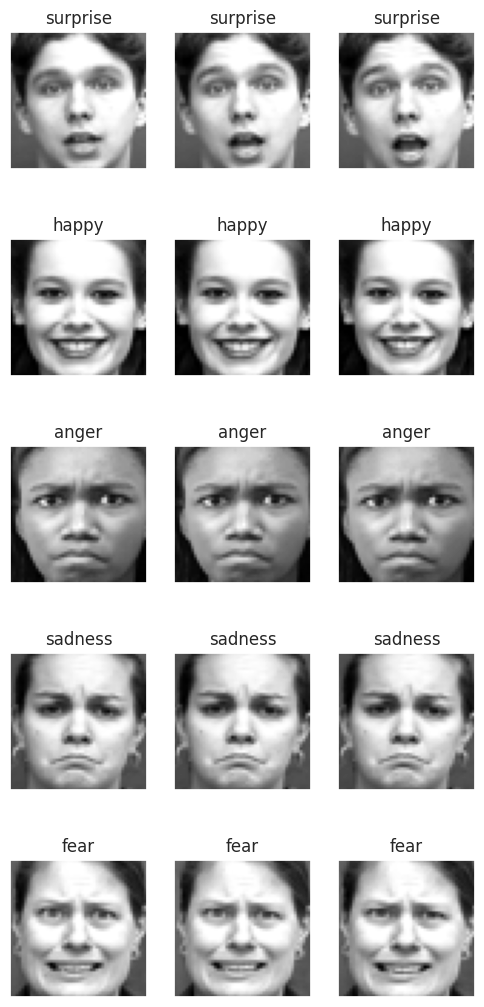

In [13]:
np.random.seed(42)
surprise_idx = np.random.choice(np.where(y_train[:, 0]==1)[0], size=1)
happy_idx = np.random.choice(np.where(y_train[:, 1]==1)[0], size=1)
anger_idx = np.random.choice(np.where(y_train[:, 2]==1)[0], size=1)
sad_idx = np.random.choice(np.where(y_train[:, 3]==1)[0], size=1)
fear_idx = np.random.choice(np.where(y_train[:, 4]==1)[0], size=1)

fig = pyplot.figure(1, (6,13))

i = 0
for name, idx in zip(label_emotion_mapper.values(), [surprise_idx, happy_idx, anger_idx, sad_idx, fear_idx]):
    for j in range(3):
        i += 1
        ax = pyplot.subplot(5,3,i)
        sample_img = X_train[idx][0,j,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(name)

****Creating FER Model****

In [14]:
# data normalization
X_train = X_train / 255.
X_valid = X_valid / 255.

In [15]:
def build_dcnn(input_shape, show_arch=True):
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            input_shape=input_shape,
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.45, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.45, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.4, name='dropout_3'))

    net.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_7'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    net.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_8'
        )
    )
    net.add(BatchNormalization(name='batchnorm_8'))
    
    net.add(Dropout(0.4, name='dropout_4'))
    
    net.add(GlobalMaxPool2D(name="globalmax2d"))
    
    if show_arch:
        net.summary()
    
    return net

In [16]:
def memory_model(input_shape, num_class, show_arch=True):
    dcnn = build_dcnn(input_shape[1:], show_arch=False)
    
    model = Sequential(name="convolutional_Bidrectional_LSTM")

    model.add(
        TimeDistributed(
            dcnn,
            input_shape=input_shape,
            name="time_distributed",
        )
    )
    
    model.add(Bidirectional(LSTM(128, return_sequences=True, name="bidirect_lstm_1")))
    model.add(Dropout(.35, name="dropout_1"))
    model.add(Bidirectional(LSTM(64, return_sequences=False, name="bidirect_lstm_2")))
    model.add(Dropout(.45, name="dropout_2"))

    model.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    model.add(BatchNormalization(name='batchnorm_1'))
    model.add(Dropout(.7, name="dropout_3"))

    model.add(
        Dense(
            num_class,
            activation='softmax',
            name='out_layer'
        )
    )
    
    if show_arch:
        model.summary()
    
    return model

In [17]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.8,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    lr_scheduler,
]

batch_size = 32
epochs = 100

In [18]:
INPUT_SHAPE = (3, 48, 48, 1)
optim = optimizers.Nadam(0.001)

model = memory_model(INPUT_SHAPE, num_class=5)
model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

I0000 00:00:1758553920.638468      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758553920.639193      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` 

Model: "convolutional_Bidrectional_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 3, 512)         │     4,691,904 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 3, 256)         │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,530,309 (21.10 MB)

 Trainable params: 5,526,213 (21.08 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [19]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_valid, y_valid),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks
)


Epoch 1/100


E0000 00:00:1758553949.411287      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/convolutional_Bidrectional_LSTM_1/time_distributed_1/dropout_1_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1758553950.816830     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 678ms/step - accuracy: 0.2259 - loss: 2.8231 - val_accuracy: 0.2800 - val_loss: 1.6322 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.2475 - loss: 2.8120 - val_accuracy: 0.2933 - val_loss: 1.7305 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.2306 - loss: 2.9383 - val_accuracy: 0.2800 - val_loss: 1.7111 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.1833 - loss: 3.4205 - val_accuracy: 0.2800 - val_loss: 1.7265 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.1571 - loss: 3.1434 - val_accuracy: 0.2933 - val_loss: 1.7083 - learning_rate: 0.0010
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.2361 - loss: 3.0096 - val_accuracy: 0.2533 - val_loss: 1.7023 - learning_rate: 0.0010
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.2412 - loss: 2.8435 - val_accuracy: 0.16

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

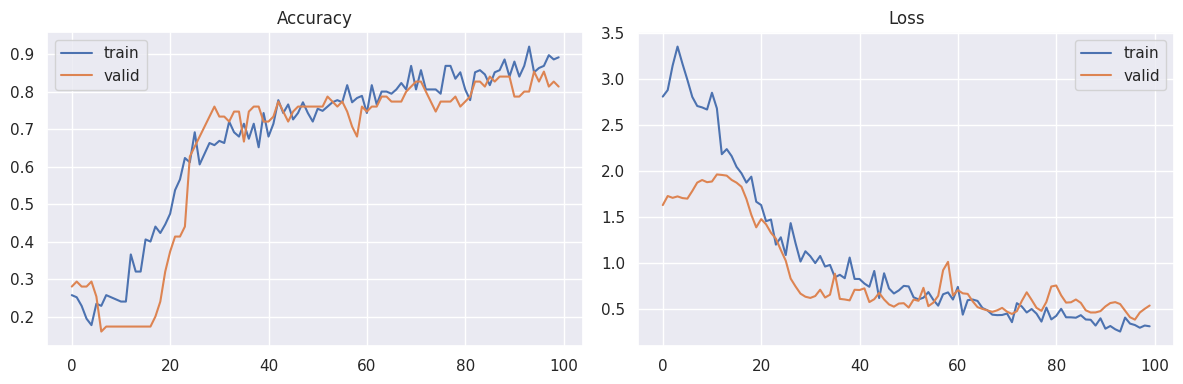

In [20]:
import seaborn as sns
import matplotlib.pyplot as pyplot

sns.set()
fig = pyplot.figure(0, (12, 4))

# Plot Accuracy
ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

# Plot Loss
ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


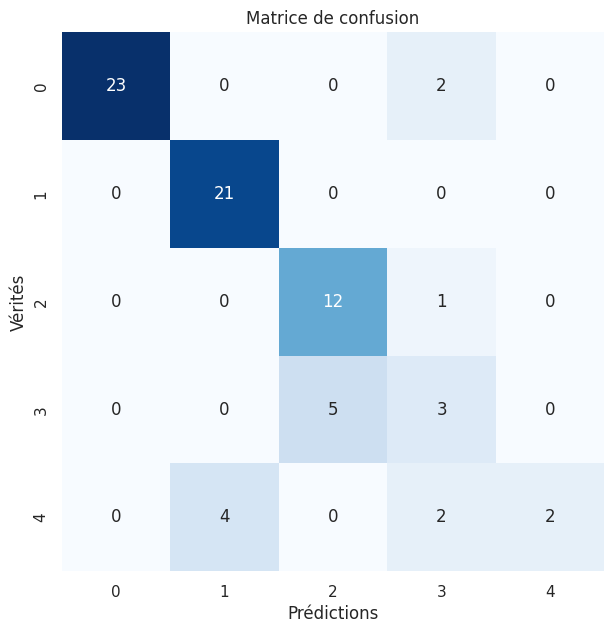

total wrong validation predictions: 14

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        25
           1       0.84      1.00      0.91        21
           2       0.71      0.92      0.80        13
           3       0.38      0.38      0.38         8
           4       1.00      0.25      0.40         8

    accuracy                           0.81        75
   macro avg       0.78      0.69      0.69        75
weighted avg       0.84      0.81      0.80        75



In [27]:
import numpy as np
import matplotlib.pyplot as pyplot
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Prédictions
yhat_probs = model.predict(X_valid)

# Multi-classe vs binaire
if yhat_probs.shape[1] > 1:
    yhat_valid = np.argmax(yhat_probs, axis=1)
    y_true = np.argmax(y_valid, axis=1)
else:
    yhat_valid = (yhat_probs > 0.5).astype("int32").ravel()
    y_true = y_valid.ravel()

# Matrice de confusion
cm = confusion_matrix(y_true, yhat_valid)

pyplot.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
pyplot.xlabel("Prédictions")
pyplot.ylabel("Vérités")
pyplot.title("Matrice de confusion")
pyplot.savefig("confusion_matrix_dcnn.png")
pyplot.show()

# Nombre d'erreurs
print(f"total wrong validation predictions: {np.sum(y_true != yhat_valid)}\n")

# Rapport complet
print(classification_report(y_true, yhat_valid))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


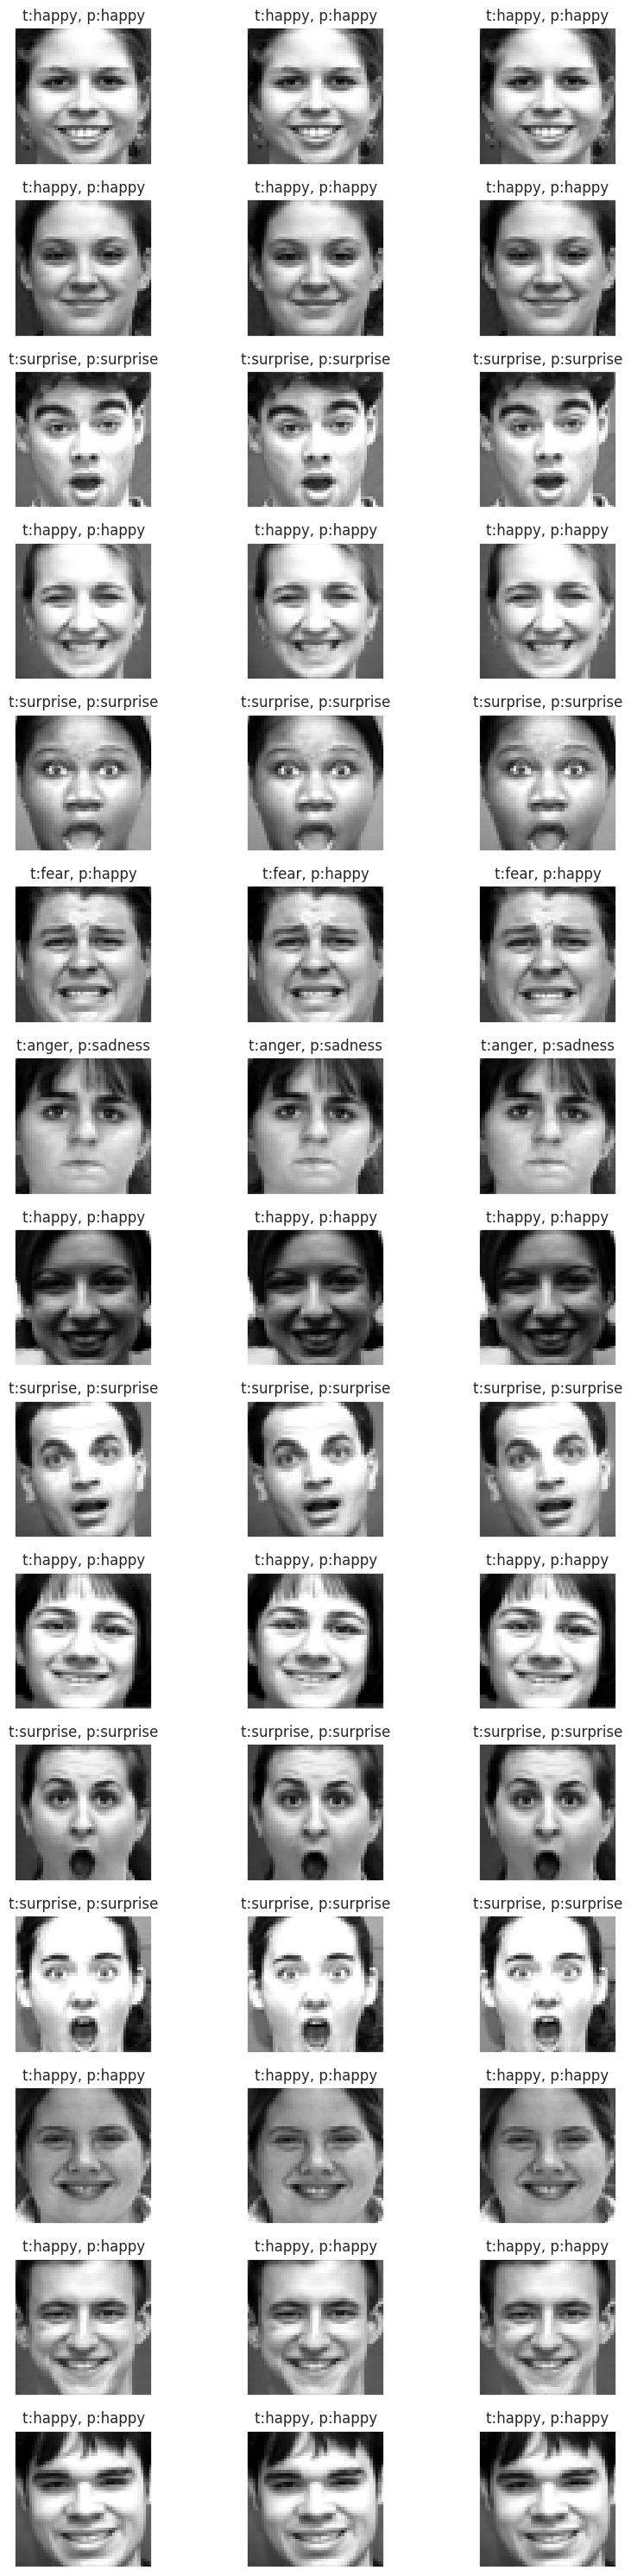

In [30]:
np.random.seed(0)
indices = np.random.choice(range(X_valid.shape[0]), size=15, replace=False)

fig = pyplot.figure(1, (9, 30))

i = 0
for idx in indices:
    true_emotion = label_emotion_mapper[np.argmax(y_valid[idx])]
    
    # Get prediction, apply argmax to get class index
    pred_class = np.argmax(model.predict(np.expand_dims(X_valid[idx], axis=0)))
    pred_emotion = label_emotion_mapper[pred_class]
    
    for j in range(3):
        i += 1
        ax = pyplot.subplot(15, 3, i)
        sample_img = X_valid[idx, j, :, :, 0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:{true_emotion}, p:{pred_emotion}")

pyplot.tight_layout()
pyplot.savefig("sample_predictions.png")
pyplot.show()


In [31]:
model.save("DCNN_model.h5")